In [342]:
import os
import re
import collections
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset # required to read sea data
from datetime import datetime, timedelta
import time
from scipy.interpolate import UnivariateSpline, splev, splrep



from et_utils import *
from et_dataset import *
from et_analytics import *
%load_ext autoreload
%autoreload 2

plt.rcParams['font.size'] = '16'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [343]:
save_plots = True
fn_plot_name = lambda name: os.path.join(download_folder, datetime(year, month, 1).strftime('%Y%m') + '-' + name + '.png')

# Data
## Download

In [344]:
# Download wait time interval (in seconds)
dn_wait_in_sec = 12 * 60 * 60 

# file names
download_folder = os.path.join(Path.home(), 'tmp', 'et')
# Sea temperature data
sea_file_name = r'sst.mnmean.nc' # file name
sea_url_base = r'https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/'
sea_url = sea_url_base + sea_file_name
sea_data_file = os.path.join(download_folder, sea_file_name)

# Land temperature data
land_file_name = r'ghcnm.tavg.latest.qcu.tar.gz'
land_url_base = r'https://www.ncei.noaa.gov/pub/data/ghcn/v4/'
land_url = land_url_base + land_file_name
land_data_tgz = os.path.join(download_folder, land_file_name)

# Land country file
land_country_url = r'https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm-countries.txt'
land_country_file = os.path.join(download_folder, 'ghcnm-countries.txt')

# download again if the wait interval has elapsed. 
if (time.time() - os.path.getctime(download_folder)) > dn_wait_in_sec:
    print('remove contents in the download folder')
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
    ! {'rm -rf ' + os.path.join(download_folder, '*')}
    print('downloading sea data')
    ! {'wget -O ' + sea_data_file + ' ' + sea_url}
    print('downloading land data')
    ! {'wget -O ' + land_data_tgz + ' ' + land_url}
    print('extrat')
    ! {'tar zxvf ' + land_data_tgz + ' -C ' + download_folder}

    print('downloading land country data')
    ! {'wget -O ' + land_country_file + ' ' + land_country_url}

# land data files
def find_file(folder, pattern):
    candidates = [f for f in os.listdir(folder) if re.match(pattern, f)]
    if len(candidates) != 1:
        print(os.listdir(folder))
        print(candidates)
        print('There must be a single file matching the pattern.')
        raise
    
    return os.path.join(folder, candidates[0])
    
land_data_folder = find_file(download_folder, r'^ghcnm.v')
land_dat_file = find_file(land_data_folder, r'^.*\.dat$')
land_inv_file = find_file(land_data_folder, r'^.*\.inv$')

print('dat file', land_dat_file, 'inv file', land_inv_file)


dat file /home/youngsuklee/tmp/et/ghcnm.v4.0.1.20220812/ghcnm.tavg.v4.0.1.20220812.qcu.dat inv file /home/youngsuklee/tmp/et/ghcnm.v4.0.1.20220812/ghcnm.tavg.v4.0.1.20220812.qcu.inv


## Sea Temperature data

In [345]:
sea_ds = SeaDataset(sea_data_file)

## Land Temperature data

In [346]:
# read from pickle if it is there. do a simple time stamp check against the downloaded file
pkl_file = land_dat_file.replace('.dat', '.pkl')
if os.path.exists(pkl_file) and (os.path.getmtime(pkl_file) > os.path.getmtime(land_data_tgz)):
    read_from_pickle=True
else:
    read_from_pickle=False

land_ds = LandDataset(land_inv_file, land_country_file, land_dat_file, pkl_file, read_from_pickle)

read from /home/youngsuklee/tmp/et/ghcnm.v4.0.1.20220812/ghcnm.tavg.v4.0.1.20220812.qcu.pkl


# Data Consolidation and Cleaning

Sea data
* Already rectangularised and cleaned. 
* The values corresponding to land coordinates are assigned to Nan. 
* So, nothing to do. 

Land data
* .dat file is 
* Stored by station locations: combine .inv and countries file. 
* Data needs to be cleaned. 

Process:
* Use the (lon,lat) coordinates from the sea data. 
* For coordinates with valid sea data, use them 'as-is'. 
* For coordinates with invalid sea data, use the land data through averaging. 
To this end, 
* Clean the land data: For each data point, take neighbouring points. Remove the point is it is deemed to be an outlier. 
* Use a kernel smoothing method over neighbouring points. 

Notes:
* Earth radius is roughly 6371km. 
* Distances are defined as the great-circle distance. 

## Analysis on specific month

In [347]:
# raw land data to work with
year, month = 2022, 7
ltd_raw = land_ds.month_data(year,month).create_with_valid_data()

## cleaning land temperature data

In [348]:
# data cleansing
## unpack the data
lon, lat, cel = ltd_raw.get_data()

# combine local (via neighbouring points) and global (via spline fit) error bands

## parameters
perc_lmu = [0.05, 0.5, 0.95]
band_scale_factor = 4.0

## processes
### 1. local fits & error band
K = 50 # neighbouring points
nbh_idx, _ = get_neighbours(lon, lat, K)
nbh_band = np.quantile(cel[nbh_idx], perc_lmu, axis=1)

### 2. global fit & error band
cel_sp = spline_fit_lat(lat, cel)
sp_band = cel_sp + np.quantile(cel_sp - cel, perc_lmu, keepdims=True)

### 3. combine error bands
comb_band = combine_bands([nbh_band, sp_band], band_scale_factor, np.mean)

## identify outliers
outliers = np.where((cel < comb_band[0]) | (cel > comb_band[2]))[0]

## remove outliers and define cleaned land temperature data
ltd_clnd = ltd_raw.remove_data(outliers)

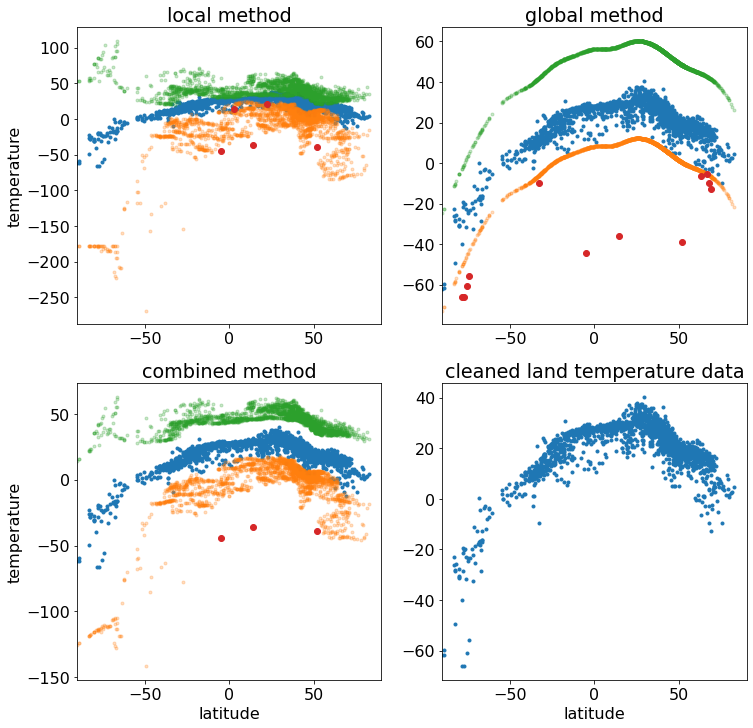

In [366]:
# visualise
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
lon, lat, cel = ltd_raw.get_data()
local_band = scale_band(nbh_band, band_scale_factor)
local_outliers = (cel < local_band[0]) | (cel > local_band[2])
plt.plot(lat, cel, '.')
plt.plot(lat, local_band[[0,2]].T, '.', alpha=0.25)
plt.plot(lat[local_outliers], cel[local_outliers], 'o')
plt.xlim(-90, 90), plt.ylabel('temperature'), plt.title('local method')
plt.subplot(2,2,2)
lon, lat, cel = ltd_raw.get_data()
global_band = scale_band(sp_band, band_scale_factor)
global_outliers = (cel < global_band[0]) | (cel > global_band[2])
plt.plot(lat, cel, '.')
plt.plot(lat, global_band[[0,2]].T, '.', alpha=0.25)
plt.plot(lat[global_outliers], cel[global_outliers], 'o')
plt.title('global method')
plt.xlim(-90, 90)
plt.subplot(2,2,3)
lon, lat, cel = ltd_raw.get_data()
plt.plot(lat, cel, '.')
plt.plot(lat, comb_band[[0,2]].T, '.', alpha=0.25)
plt.plot(lat[outliers], cel[outliers], 'o', label='outliers')
plt.xlim(-90, 90), plt.xlabel('latitude'), plt.ylabel('temperature'), plt.title('combined method')
plt.subplot(2,2,4)
lon, lat, cel = ltd_clnd.get_data()
plt.plot(lat, cel, '.', label='data (cleaned')
plt.xlim(-90, 90), plt.xlabel('latitude'), plt.title('cleaned land temperature data')
if save_plots:
    plt.savefig(fn_plot_name('outliers'),bbox_inches='tight')
plt.show()

## Combining land and sea data

In [350]:
# sea temperature data of the month
std_raw = sea_ds.month_data(year, month)

## check the parameter

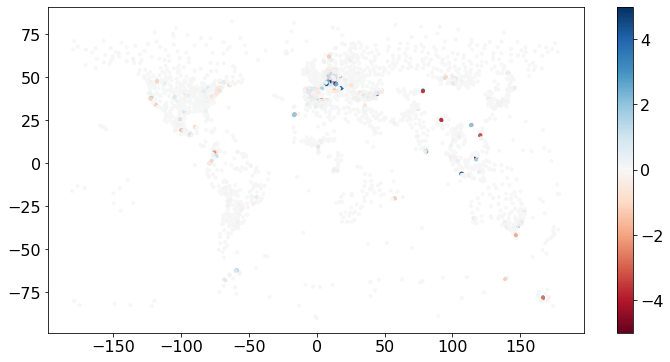

In [351]:
# parameters
k_wid = circle_distance(0,0,0,1) / 2

# first, test how good the averaging works where the data are. 
lon, lat, Z = ltd_clnd.get_data()
Z_a = average_over_sphere(lon, lat, Z, lon, lat, k_wid)

plt.figure(figsize=(12,6))
plt.scatter(lon, lat, marker='.', c = Z - Z_a, cmap='RdBu', vmin=-5, vmax=5)
plt.colorbar()
plt.show()


## Inference

In [352]:
# data to infer via averaging
lon, lat, Z = ltd_clnd.get_data()
# Full data points. To fill nan points.
lon_f, lat_f, Z_f = std_raw.get_data()
idx_a = np.isnan(Z_f) # indices where the value is nan, to be filled
lon_a, lat_a = lon_f[idx_a], lat_f[idx_a]

# infer
Z_a = average_over_sphere(lon, lat, Z, lon_a, lat_a, k_wid)
Z_filled = Z_f.copy()
Z_filled[idx_a] = Z_a # assign
td_comb = TemperatureData(year, month, lon_f, lat_f, Z_filled)

## Plotting

In [353]:
vmin, vmax = -40, 40

### land, sea and combined data

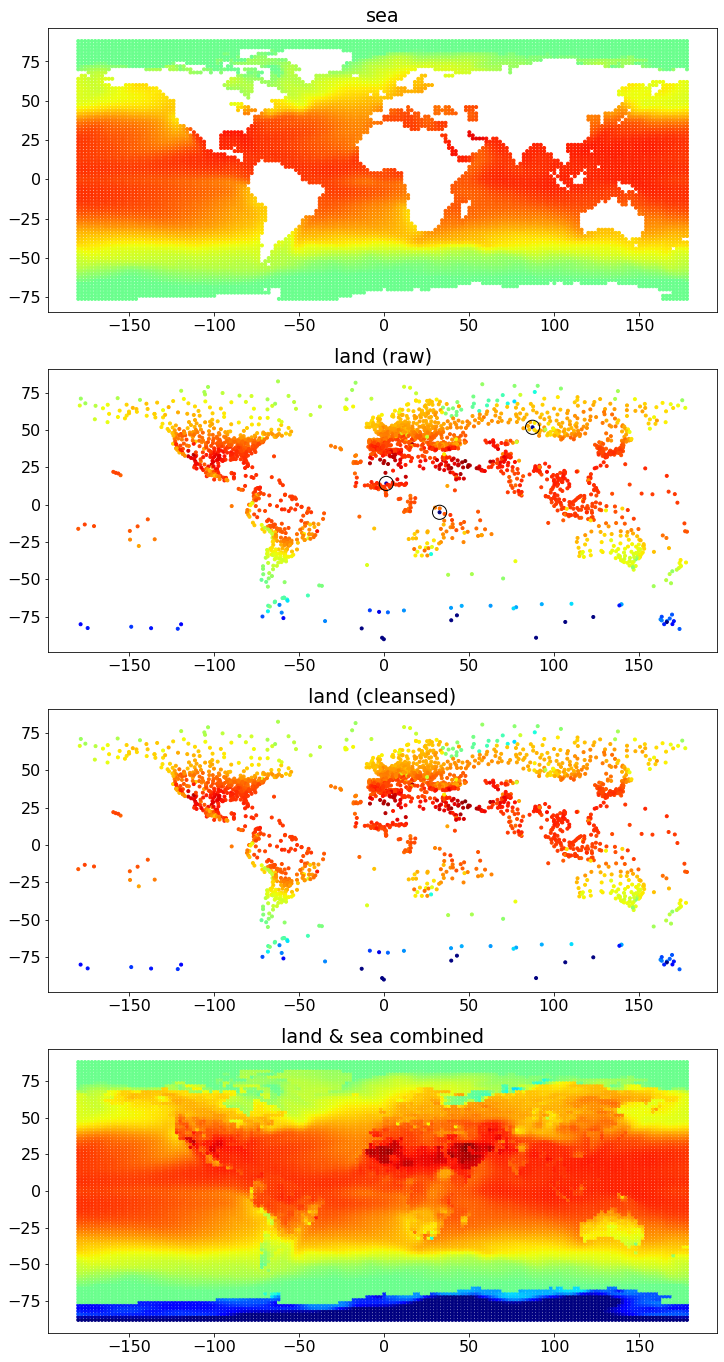

In [362]:
# land data,, sea data, and combined
plt.figure(figsize=(12,24))
plt.subplot(4,1,1)
lon, lat, cel = std_raw.get_data()
plt.scatter(lon, lat, c=cel, marker = '.', cmap='jet', alpha=1, vmin=vmin, vmax=vmax)
plt.title('sea')
plt.subplot(4,1,2)
lon, lat, cel = ltd_raw.get_data()
plt.scatter(lon, lat, c=cel, marker = '.', cmap='jet', alpha=1, vmin=vmin, vmax=vmax)
plt.scatter(lon[outliers], lat[outliers], marker='o', s = 200, facecolor="None", edgecolor='k')
plt.title('land (raw)')
plt.subplot(4,1,3)
lon, lat, cel = ltd_clnd.get_data()
plt.scatter(lon, lat, c=cel, marker = '.', cmap='jet', alpha=1, vmin=vmin, vmax=vmax)
plt.title('land (cleansed)')
plt.subplot(4,1,4)
lon, lat, cel = td_comb.get_data()
plt.scatter(lon, lat, c=cel, marker = '.', cmap='jet', alpha=1, vmin=vmin, vmax=vmax)
plt.title('land & sea combined')
if save_plots:
    plt.savefig(fn_plot_name('data-comb'),bbox_inches='tight')
plt.show()

### Overlay with the world map

In [355]:
# make a projection first
map_projection = "ESRI:54012" # (lon,lat): "EPSG:4326", (rounded): "ESRI:54012"
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).to_crs(map_projection)

# project the temperature data
lon, lat, cel = td_comb.get_data()
lon_p, lat_p = geo_projection(lon, lat, map_projection)
td_comb_proj = TemperatureData(year, month, lon_p, lat_p, cel)

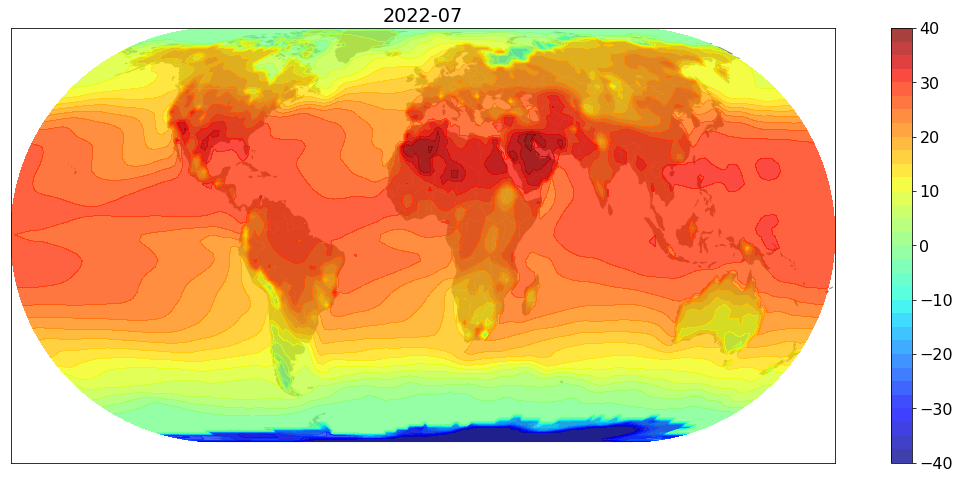

In [359]:
# create rectangular data for plotting (this is probably not required though)
M_lon, M_lat = sea_ds.M_lon, sea_ds.M_lat
lon_r, lat_r, cel_r = td_comb_proj.get_rectangular_data(M_lon, M_lat)

fig, ax = plt.subplots(figsize=(20,8))
worldmap.plot(color='grey', ax=ax)
cel_rmm = np.clip(cel_r, vmin, vmax)
plt.contourf(lon_r, lat_r, cel_rmm, levels = np.arange(vmin, vmax+1, 2.5), vmin=vmin, vmax=vmax, cmap='jet', alpha=0.75)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.title(datetime(year,month,1).strftime('%Y-%m'))
if save_plots:
    plt.savefig(fn_plot_name('contour'),bbox_inches='tight')
plt.show()